# A Data Mining Approach to NHL Salary Prediction
SENG 474
Fall 2018
Jonathan Healy (V00845624)
Carson Reid (V00856719)


# 1. Introduction
In the NHL, salaries can range from a few hundred thousand to upwards of ten million dollars. With the salary cap changing every year and players values always changing it can be very useful to be able to predict a player’s contribution to a team’s total salary. Salaries are relatively consistent with the general skill of a player, but there is no formula to compute a player’s salary. To call a player good or bad is almost always a subjective statement, and with this report we look to find out what really makes a good player objectively and how those good player metrics contribute to their salary.
We are basing our calculations purely off of recorded statistics that we can perform calculations on, so that numerical analytical algorithms can be run. The calculation of a player’s value on a certain team with certain teammates that have unique synergies on and off the ice is such an incalculable metric we are choosing to consider it noise in our data.


## Decision Tree Regressor (naive features)

In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [2]:
nhl_file_path = 'nhl_data.csv'
nhl_data = pd.read_csv(nhl_file_path)
nhl_data.dropna(axis=0, subset=['Salary'], inplace=True)

In [3]:
# dropna drops missing values (think of na as "not available")
nhl_data = nhl_data.dropna(axis=0)

In [4]:
y = nhl_data.Salary

In [5]:
nhl_features = ['Age', 'G', 'A', 'PTS', '+/-', 'Shifts']

In [6]:
X = nhl_data[nhl_features]

In [7]:
# Define model. Specify a number for random_state to ensure same results each run
nhl_model = DecisionTreeRegressor(random_state=0)

In [8]:
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we run this script.
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)
nhl_model.fit(train_X, train_y)
val_predictions = nhl_model.predict(val_X)
print(mean_absolute_error(val_y, val_predictions))

3047222.222222222


## Decision Tree Regressor using Max Leaf Nodes

In [9]:
# underfitting/ overfitting
# compore mae scores from different value for max leaf nodes
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

In [10]:
# compare MAE with differing values of max_leaf_nodes
candidate_max_leaf_nodes = [5, 25, 50, 100, 250, 500]

for max_leaf_nodes in [5, 50, 500, 5000]:
    my_mae = get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y)
    print("Max leaf nodes: %d  \t\t Mean Absolute Error:  %d" %(max_leaf_nodes, my_mae))

Max leaf nodes: 5  		 Mean Absolute Error:  2730634
Max leaf nodes: 50  		 Mean Absolute Error:  2569444
Max leaf nodes: 500  		 Mean Absolute Error:  2569444
Max leaf nodes: 5000  		 Mean Absolute Error:  2569444


In [11]:
scores = {leaf_size: get_mae(leaf_size, train_X, val_X, train_y, val_y) for leaf_size in candidate_max_leaf_nodes}
best_tree_size = min(scores, key=scores.get)

In [12]:
# Fit the model with best_tree_size. Fill in argument to make optimal size
final_model = DecisionTreeRegressor(max_leaf_nodes=best_tree_size, random_state=0)

# fit the final model
final_model.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=25, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

In [13]:
# get predicted prices on validation data
val_predictions = final_model.predict(val_X)
print(mean_absolute_error(val_y, val_predictions))

78888.88888888889


## Random Forests

In [14]:
from sklearn.ensemble import RandomForestRegressor

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [15]:
forest_model = RandomForestRegressor(random_state=0)
forest_model.fit(train_X, train_y)
nhl_preds = forest_model.predict(val_X)
print(mean_absolute_error(val_y, nhl_preds))

2508611.111111111


## XG Boost

In [16]:
from sklearn.preprocessing import Imputer
from xgboost import XGBRegressor

In [17]:
data = pd.read_csv('nhl_data.csv')
data.dropna(axis=0, subset=['Salary'], inplace=True)

y = data.Salary
nhl_features = ['Age', 'G', 'A', 'PTS', '+/-', 'Shifts']

X = data[nhl_features]
data = data.dropna(axis=0)
train_X, test_X, train_y, test_y = train_test_split(X.as_matrix(), y.as_matrix(), test_size=0.25)

my_imputer = Imputer()
train_X = my_imputer.fit_transform(train_X)
test_X = my_imputer.transform(test_X)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [18]:
my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(train_X, train_y, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [19]:
# make predictions
predictions = my_model.predict(test_X)
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error : 1094305.2680995476


### XG Boost with n-estimators

In [20]:
# n-estimators = how many times to go through the model size above
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(train_X, train_y, early_stopping_rounds=5, 
             eval_set=[(test_X, test_y)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [21]:
predictions = my_model.predict(test_X)
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error : 1083849.3093891402


### XG Boost with learning rate and n-estimators

In [22]:
# learning - rate
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(train_X, train_y, early_stopping_rounds=5, 
             eval_set=[(test_X, test_y)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [23]:
predictions = my_model.predict(test_X)
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error : 1075926.1832579186


## Visualization with Partial Dependence Plots and Decision Tree

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from pdpbox import pdp, get_dataset, info_plots
from sklearn import tree
import graphviz

In [25]:
data = pd.read_csv('nhl_data.csv')
y = (data['Salary'] > 950000)  # Convert from string "Yes"/"No" to binary
feature_names = ['Age', 'G', 'A', 'PTS', '+/-']
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=3, min_samples_split=5).fit(train_X, train_y)

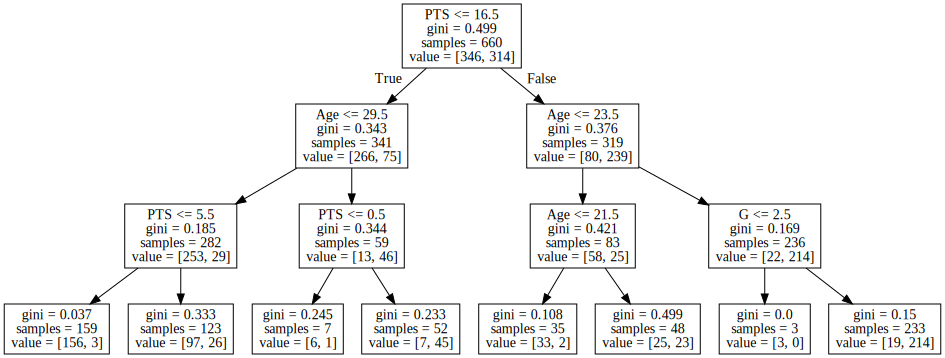

In [26]:
tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=feature_names)
graphviz.Source(tree_graph)

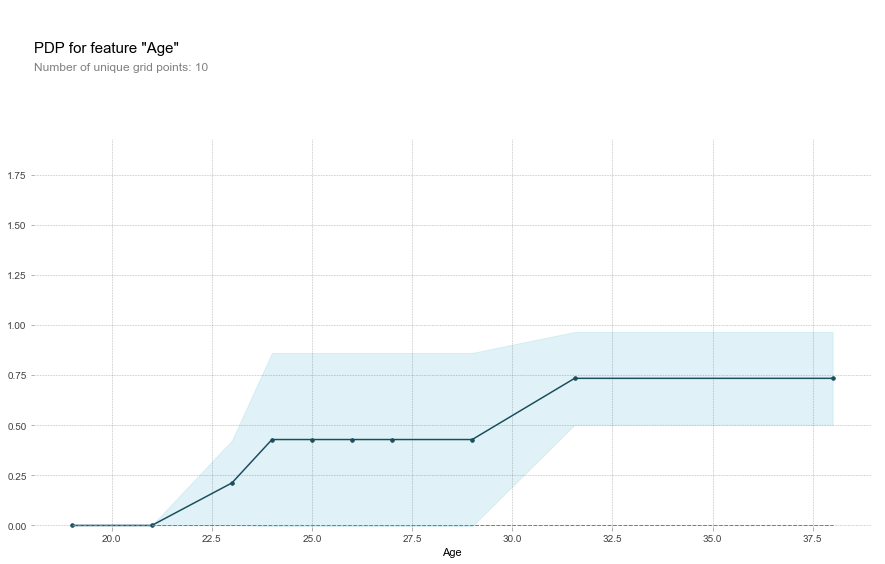

In [27]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=feature_names, feature='Age')

# plot it
pdp.pdp_plot(pdp_goals, 'Age')
plt.show()

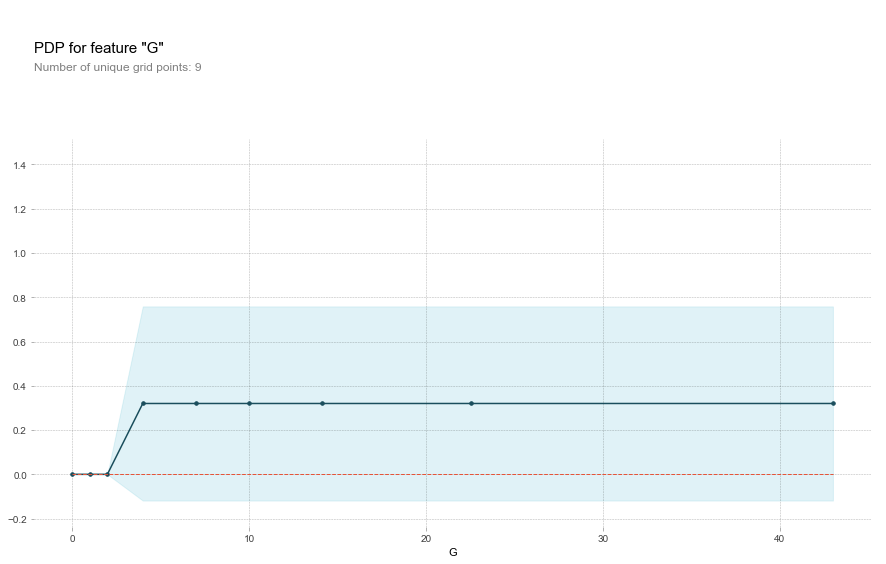

In [28]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=feature_names, feature='G')

# plot it
pdp.pdp_plot(pdp_goals, 'G')
plt.show()

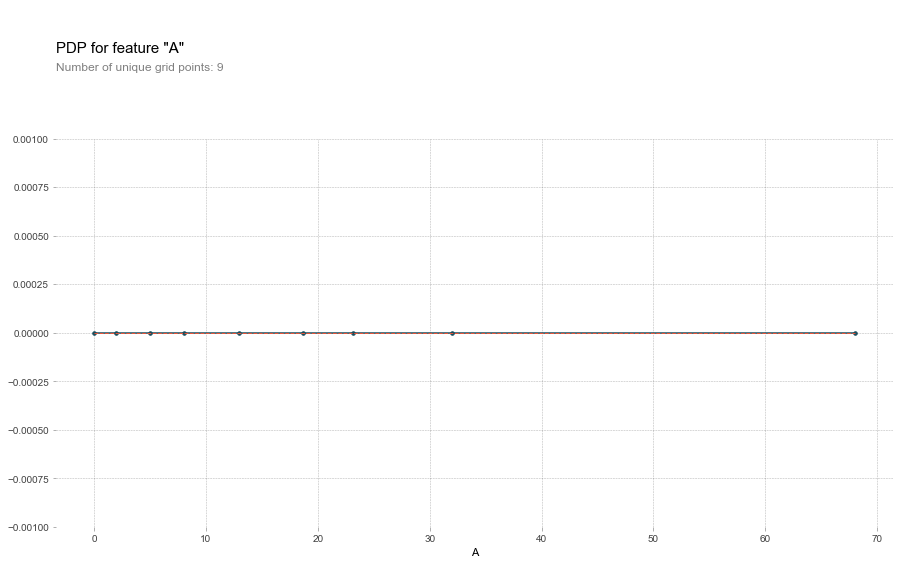

In [29]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=feature_names, feature='A')

# plot it
pdp.pdp_plot(pdp_goals, 'A')
plt.show()

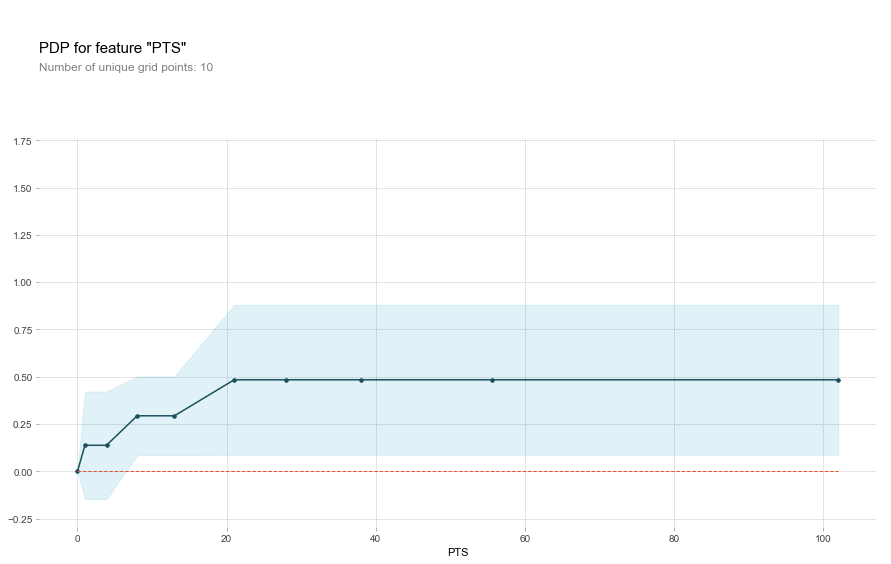

In [30]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=feature_names, feature='PTS')

# plot it
pdp.pdp_plot(pdp_goals, 'PTS')
plt.show()

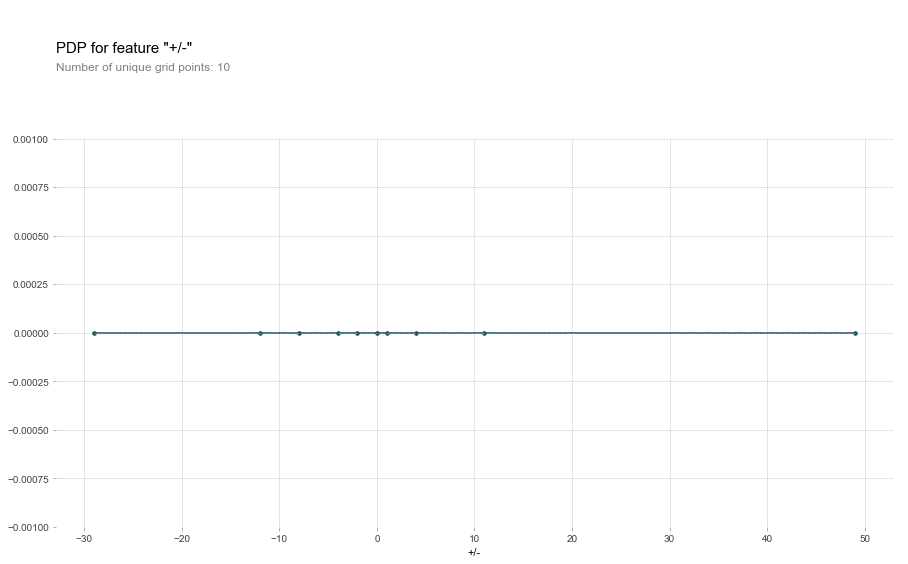

In [31]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=feature_names, feature='+/-')

# plot it
pdp.pdp_plot(pdp_goals, '+/-')
plt.show()

## Feature Selection with XG Boost

In [32]:
# gradient boosting with XG Boost
# https://www.datacamp.com/community/tutorials/xgboost-in-python
import xgboost as xgb

In [33]:
data = pd.read_csv('nhl_data.csv')
y = data.Salary
# extended feature list --- could add to this
nhl_features = ['Ovrl', 'Age', 'PTS/GP', 'TOI/GP', 'TOff/60', 'C-PTS', 'PTS', 'Star', 'G', 'A', 'iSF',
                'iHF', 'Over', 'CriG', 'xGF', 'CF', 'SF', 'FF']
X = data[nhl_features]
data = data.dropna(axis=0)

In [34]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [36]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)

In [37]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

In [38]:
print("Mean Absolute Error : " + str(mean_absolute_error(preds, y_test)))

Mean Absolute Error : 710844.9463276836


In [39]:
# k-fold cross validation (3 fold model here)
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

In [40]:
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                  num_boost_round=50,early_stopping_rounds=10,metrics="mae", as_pandas=True, seed=123)
#cv_results.head()
print((cv_results["test-mae-mean"]).tail(1))

[15:36:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[15:36:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:36:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:36:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:36:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[15:36:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:36:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:36:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[15:36:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_

In [41]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10, verbose_eval=50)

[15:36:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[15:36:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[15:36:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[15:36:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:36:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:36:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[15:36:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[15:36:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[15:36:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_

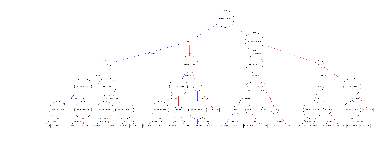

In [42]:
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [100, 100]
plt.show()

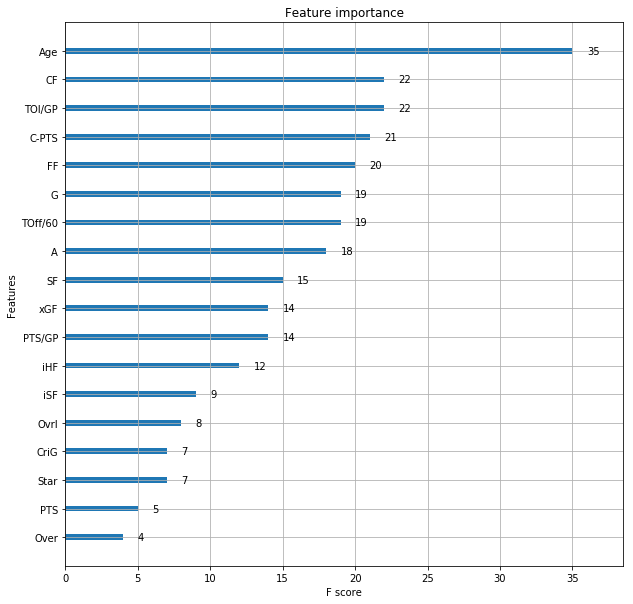

In [44]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

## Decision Tree Regressor (improved features)

In [45]:
nhl_file_path = 'nhl_data.csv'
nhl_data = pd.read_csv(nhl_file_path)
nhl_data.dropna(axis=0, subset=['Salary'], inplace=True)

In [46]:
# dropna drops missing values (think of na as "not available")
nhl_data = nhl_data.dropna(axis=0)
y = nhl_data.Salary
nhl_features = ['Age', 'CF', 'A', 'C-PTS', 'TOI/GP', 'xGF', 'TOff/60']
X = nhl_data[nhl_features]
# Define model. Specify a number for random_state to ensure same results each run
nhl_model = DecisionTreeRegressor(random_state=0)

In [47]:
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we run this script.
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)
nhl_model.fit(train_X, train_y)
val_predictions = nhl_model.predict(val_X)
print(mean_absolute_error(val_y, val_predictions))

1963888.888888889


Mean absolute error before improved features = 3047222
After improved features = 1963888

## Decision Tree Regressor with Max Leaf Nodes (improved features)

In [48]:
# underfitting/ overfitting
# compore mae scores from different value for max leaf nodes
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

In [49]:
# compare MAE with differing values of max_leaf_nodes
candidate_max_leaf_nodes = [5, 25, 50, 100, 250, 500]

for max_leaf_nodes in [5, 50, 500, 5000]:
    my_mae = get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y)
    print("Max leaf nodes: %d  \t\t Mean Absolute Error:  %d" %(max_leaf_nodes, my_mae))

Max leaf nodes: 5  		 Mean Absolute Error:  2021141
Max leaf nodes: 50  		 Mean Absolute Error:  1908333
Max leaf nodes: 500  		 Mean Absolute Error:  1908333
Max leaf nodes: 5000  		 Mean Absolute Error:  1908333


In [50]:
scores = {leaf_size: get_mae(leaf_size, train_X, val_X, train_y, val_y) for leaf_size in candidate_max_leaf_nodes}
best_tree_size = min(scores, key=scores.get)

In [51]:
# Fit the model with best_tree_size. Fill in argument to make optimal size
final_model = DecisionTreeRegressor(max_leaf_nodes=best_tree_size, random_state=0)

# fit the final model
final_model.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=25, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

In [52]:
# get predicted prices on validation data
val_predictions = final_model.predict(val_X)
print(mean_absolute_error(val_y, val_predictions))

25000.0


Mean absolute error before improved features = 78888
After improved features = 25000